In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import random
import cv2
import copy
import os
from sklearn.model_selection import train_test_split
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.models as models
from torchvision.utils import make_grid
import torchvision.transforms as transform
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from IPython.display import display

# from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### 1. 데이터 살펴보기
- 데이터 경로 지정
- 샘플 이미지 눈으로 확인하기
- 데이터 불균형 여부 확인하기
- directory of data (same for all train, val, test sets)
    - /data
    - /data/chest_xray
    - /data/chest_xray/train
    - /data/chest_xray/train/NORMAL
    - /data/chest_xray/train/PNEUMONIA 

In [2]:
path = "data/chest_xray"
train_path = "data/chest_xray/train"
test_path = "data/chest_xray/test"
val_path = "data/chest_xray/val"

In [3]:
from PIL import Image

def show_random_images(path_normal, path_pneumonia):
    path_random_normal = random.choice(path_normal)
    path_random_pneumonia = random.choice(path_pneumonia)

    # convert를 이용해 원하는 형식으로 이미지를 불러올 수 있다. (RGB, L, CMYK)
    image_normal = Image.open(path_random_normal).convert("L") # LA: 흑백, non-alpha
    image_pneumonia = Image.open(path_random_pneumonia).convert("L")

    # 이미지 채널을 확인한다.
    channel_normal = image_normal.mode
    channel_pneumonia = image_pneumonia.mode

    # 이미지의 사이즈 (width, height)를 확인한다. 
    size_normal = image_normal.size
    size_pneumonia = image_pneumonia.size

    fig = plt.figure(figsize=(10, 6))

    ax1 = plt.subplot(1, 2, 1)
    ax1.imshow(image_normal, cmap='gray')
    ax1.set_title(f"Normal X-ray\n({size_normal[0]}, {size_normal[1]}, {channel_normal})")

    ax2 = plt.subplot(1, 2, 2)
    ax2.imshow(image_pneumonia, cmap='gray')
    ax2.set_title(f"Pneumonia X-ray\n({size_pneumonia[0]}, {size_pneumonia[1]}, {channel_pneumonia})")

    plt.show()


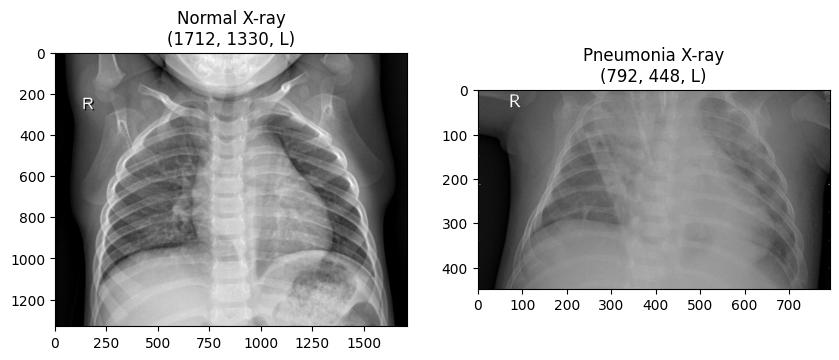

In [4]:
import glob 

train_normal = glob.glob(train_path + "/NORMAL/*")  # 선택한 디렉토리 안에 있는 모든 이미지 파일에 대한 경로를 반환한다. 
train_pneumonia = glob.glob(train_path + "/PNEUMONIA/*")

show_random_images(train_normal, train_pneumonia)

In [11]:
# 디렉토리에 이미지가 몇개씩 들어가있는지 확인
def get_sample_counts(folder_path):
    return {
        "Normal": len([os.path.join(folder_path + "/NORMAL", filename) 
                       for filename in os.listdir(folder_path + "/NORMAL")]),
        "Pneumonia": len([os.path.join(folder_path + "/PNEUMONIA", filename) 
                          for filename in os.listdir(folder_path + "/PNEUMONIA")])
    }

       Normal  Pneumonia
train    1106       3640
test      234        390
val       243        243


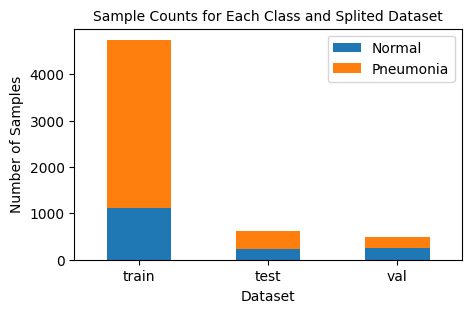

In [12]:
train_sample_counts = get_sample_counts(train_path)
test_sample_counts = get_sample_counts(test_path)
val_sample_counts = get_sample_counts(val_path)

# Create a DataFrame from the dictionaries
data_counts = pd.DataFrame([train_sample_counts, test_sample_counts, val_sample_counts], index=['train', 'test', 'val'])
print(data_counts)

# Plotting
data_counts.plot(kind='bar', stacked=True, figsize=(5, 3))
plt.title('Sample Counts for Each Class and Splited Dataset', fontsize = 10)
plt.xlabel('Dataset')
plt.xticks(rotation=0)
plt.ylabel('Number of Samples')
plt.show()

bar chart를 보면 train set에서 NORMAL이 PNEUMONIA보다 훨씬 적은 불균형 문제를 확인할 수 있다. 이는 data augmentation에서 NORMAL 이미지 수를 늘려서 해소해보려고 한다. 

### 2. 데이터셋 & 데이터 로더
- Normalization, Data Augmentation
- dataset, data loader

In [13]:
# To get mean and std from images for normalization setup
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

train_ds = ImageFolder(train_path, transform=transforms.Compose(
    [transforms.Resize((224, 224)),  # resize images to speed up the training process later
     transforms.ToTensor()]))
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=32, shuffle=False)

def get_mean_std(loader):
    mean = 0.0
    std = 0.0
    total_pixels_count = 0

    for images, _ in loader:
        num_pixels_per_batch = images.size(0)  
        images = images.flatten(1)
        mean += torch.mean(images)
        std += torch.std(images)
        total_pixels_count += num_pixels_per_batch

    mean /= total_pixels_count
    std /= total_pixels_count

    return mean, std

In [8]:
# get_mean_std(train_dl)  # takes about 2 mins
# output: (tensor(0.0151), tensor(0.0074))

From the above method, we can only get the approximation of mean and std. 
If we want to get the exact mean, std, whole dataset should be load at once but it will cost a lot of resources.  

In [14]:
# calculated mean and std
train_mean = 0.0151
train_std = 0.0074

Since we only want to increase NORMAL label dataset to solve data imbalance problem, let's create a custom dataset. 

In [69]:
def make_dataset(data_path, transform1, transform2, resizing, target_label):
  """
  NORMAL 라벨에만 변환을 적용하는 데이터셋을 생성합니다.

  Args:
    data_path: 데이터 경로
    transform: 변환 함수
    resizing: 이미지 사이즈 수정 함수
    target_label: NORMAL 라벨

  Returns:
    tuple: 이미지 경로와 라벨 쌍 목록
  """
  normal_trans1_ds = []
  normal_trans2_ds = []
  normal_resized_ds = []
  pneumonia_resized_ds = []
  label_fn = lambda label: 0 if label == target_label else 1

  for root, dirs, files in os.walk(data_path):
    for file in files:
      image_path = os.path.join(root, file)
      label = os.path.basename(root)
      if label == target_label:
        # NORMAL 라벨에만 augmentation 변환 적용
        normal_trans1_ds.append((transform1(Image.open(image_path).convert("L")), label_fn(label)))
        normal_trans2_ds.append((transform2(Image.open(image_path).convert("L")), label_fn(label)))
        normal_resized_ds.append((resizing(Image.open(image_path).convert("L")), label_fn(label)))
      else:
        # 다른 라벨은 변환 없이 resizing만 적용
        pneumonia_resized_ds.append((resizing(Image.open(image_path).convert("L")), label_fn(label)))

  return normal_trans1_ds, normal_trans2_ds, normal_resized_ds, pneumonia_resized_ds

  

In [35]:
# original image(only resizing) + 3 different ways to transform images for data augmentation 
transformer = {
    "original": transforms.Compose([
        transforms.Resize((224,224)),
        transform.ToTensor(),  # change image to tensor array
        # transform.RandomGrayscale(p=1),
        transforms.Normalize(train_mean, train_std) # normalization 
        ]),
    "aug_1": transforms.Compose([
        transform.Resize((224, 224)), 
        transform.RandomRotation(10),
        # transform.RandomGrayscale(p=1),
        transform.RandomAffine(translate=(0.05, 0.05), degrees=0),
        transform.ToTensor(), 
        transforms.Normalize(train_mean, train_std)  
        ]),
    "aug_2": transforms.Compose([
        transforms.Resize((224, 224)), 
        transform.RandomHorizontalFlip(p=1),
        # transform.RandomGrayscale(p=1),
        transform.RandomAffine(translate=(0.1, 0.05), degrees=10),
        transform.ToTensor(),
        transforms.Normalize(train_mean, train_std)
        ]),
    "aug_3": transforms.Compose([
        transforms.Resize((224, 224)), 
        transform.RandomRotation(15),
        transform.RandomHorizontalFlip(p=0.05),
        # transform.RandomGrayscale(p=1),
        transform.RandomAffine(translate=(0.08, 0.1), degrees=15),
        transform.ToTensor(),
        transforms.Normalize(train_mean, train_std)
        ])
}

In [70]:
normal_trans1_ds, normal_trans2_ds, normal_resized_ds, pneumonia_resized_ds = make_dataset(
    train_path, transformer["aug_1"], transformer["aug_2"],  transformer["original"], "NORMAL")

print(len(normal_trans1_ds), len(normal_trans2_ds), len(normal_resized_ds), len(pneumonia_resized_ds))


1106 1106 1106 3640


In [71]:
# combine datasets 
combined_train_ds = torch.utils.data.ConcatDataset([normal_trans1_ds, normal_trans2_ds, normal_resized_ds, 
                                                pneumonia_resized_ds])
len(combined_train_ds)

6958

In [73]:
combined_train_ds[0]

(tensor([[[ 9.6182,  8.5583,  7.4984,  ..., -2.0405, -2.0405, -2.0405],
          [ 9.6182,  9.6182,  8.0284,  ..., -2.0405, -2.0405, -2.0405],
          [10.1481,  9.6182,  8.5583,  ..., -2.0405, -2.0405, -2.0405],
          ...,
          [-2.0405, -2.0405, -2.0405,  ..., -2.0405, -2.0405, -2.0405],
          [-2.0405, -2.0405, -2.0405,  ..., -2.0405, -2.0405, -2.0405],
          [-2.0405, -2.0405, -2.0405,  ..., -2.0405, -2.0405, -2.0405]]]),
 0)

In [74]:
# prepare valid and test set 
valid_ds = ImageFolder(val_path, transform = transformer["original"])
test_ds = ImageFolder(test_path, transform = transformer["original"])

In [75]:
valid_ds[0]

(tensor([[[50.9536, 53.0734, 53.6033,  ..., 40.3548, 30.8158, 28.1661],
          [50.9536, 52.0135, 53.6033,  ..., 40.3548, 30.8158, 27.6362],
          [50.9536, 51.4836, 53.0734,  ..., 40.8847, 29.7560, 27.1063],
          ...,
          [-2.0405, -2.0405,  3.2589,  ..., -2.0405, -2.0405, -2.0405],
          [-2.0405, -1.5106,  4.3188,  ..., -2.0405, -2.0405, -2.0405],
          [-2.0405, -1.5106,  5.3786,  ..., -2.0405, -2.0405, -2.0405]],
 
         [[50.9536, 53.0734, 53.6033,  ..., 40.3548, 30.8158, 28.1661],
          [50.9536, 52.0135, 53.6033,  ..., 40.3548, 30.8158, 27.6362],
          [50.9536, 51.4836, 53.0734,  ..., 40.8847, 29.7560, 27.1063],
          ...,
          [-2.0405, -2.0405,  3.2589,  ..., -2.0405, -2.0405, -2.0405],
          [-2.0405, -1.5106,  4.3188,  ..., -2.0405, -2.0405, -2.0405],
          [-2.0405, -1.5106,  5.3786,  ..., -2.0405, -2.0405, -2.0405]],
 
         [[50.9536, 53.0734, 53.6033,  ..., 40.3548, 30.8158, 28.1661],
          [50.9536, 52.0135,

In [76]:
print("valid: ",len(valid_ds))
print("test: ", len(test_ds))


valid:  486
test:  624


In [85]:
# Dataloader for train and valid set first
batch = 32
# train_dl = DataLoader(combined_train_ds, batch_size=batch, shuffle=True, num_workers=4, pin_memory=True)
train_dl = DataLoader(combined_train_ds, batch_size=batch, shuffle=True)
val_dl = DataLoader(valid_ds, batch_size = batch*2, shuffle=True, num_workers=4, pin_memory=True)

loaders = {'train':train_dl, 'val':val_dl}
dataset_sizes = {'train':len(combined_train_ds), 'val':len(valid_ds)}

In [86]:
next(iter(train_dl))

[tensor([[[[ 4.8487,  6.4385,  8.5583,  ..., 11.2080,  9.6182,  6.9685],
           [ 4.3188,  5.3786,  7.4984,  ..., 10.1481,  8.0284,  5.9086],
           [ 3.7888,  4.8487,  7.4984,  ...,  8.0284,  6.4385,  5.3786],
           ...,
           [-2.0405, -2.0405, -2.0405,  ..., -2.0405, -2.0405, -2.0405],
           [-2.0405, -2.0405, -2.0405,  ..., -2.0405, -2.0405, -2.0405],
           [-2.0405, -2.0405, -2.0405,  ..., -2.0405, -2.0405, -2.0405]]],
 
 
         [[[-2.0405, -2.0405, -2.0405,  ..., -2.0405, -2.0405, -2.0405],
           [-2.0405, -2.0405, -2.0405,  ..., -2.0405, -2.0405, -2.0405],
           [-2.0405, -2.0405, -2.0405,  ..., -2.0405, -2.0405, -2.0405],
           ...,
           [-2.0405, -2.0405, -2.0405,  ..., -2.0405, -2.0405, -2.0405],
           [-2.0405, -2.0405, -2.0405,  ..., -2.0405, -2.0405, -2.0405],
           [-2.0405, -2.0405, -2.0405,  ..., -2.0405, -2.0405, -2.0405]]],
 
 
         [[[18.6272, 19.6871, 24.4565,  ..., 73.7411, 61.0225, 56.2530],
       